In [1]:
# import
import numpy as np
import cv2 as cv
import va
from ipywidgets import interact
import datetime
import math

# Calcolo istogramma

In [2]:
def calc_hist_py(img):
    h = np.zeros(256, dtype=int)
    for p in np.nditer(img):
        h[p] += 1
    return h
def calc_hist_np(img):
    return np.histogram(img,256,[0,256])[0]
def calc_hist_cv(img):
    return cv.calcHist([img], [0], None, [256], [0, 256]).squeeze()
def convert_hist_to_img(vector, max_height = 200):
    vector = max_height * (vector / max(vector))
    img = np.ndarray((max_height,256,3), dtype=np.int64)
    for i in range(256):
        for j in range(max_height):
            if(vector[i] < j):
                img[j,i] = i
            else:
                img[j,i,2] = 255
                img[j,i,1] = 204
    return img

In [3]:
@interact(img_name=["immagini/radio2.png","immagini/torre.jpg","immagini/tbbt.jpg"])
def show_hist(img_name):
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    va.show(img)
    h_py = calc_hist_py(img)
    h_np = calc_hist_np(img)
    h_cv = calc_hist_cv(img)
    va.show((convert_hist_to_img(h_py), "h_py"),(convert_hist_to_img(h_np), "h_np"),(convert_hist_to_img(h_cv), "h_cv"))

interactive(children=(Dropdown(description='img_name', options=('immagini/radio2.png', 'immagini/torre.jpg', '…

### Variazione luminosità e contrasto $f(I[y,x])=\alpha\cdot I[y,x]+\beta$
### Gamma correction $f(I[y,x])=(\frac{I[y,x]}{255})^\gamma\cdot 255$
### Contrast stretching $f(I[y,x])=255\cdot\frac{I[y,x]-\alpha}{\beta-\alpha}$

In [4]:
def apply_op(img,op):
    res = np.empty_like(img)
    h, w = res.shape
    for y in range(h):
        for x in range(w):
            pixel = op(img[y,x])
            if pixel > 255 : pixel = 255
            if pixel < 0 : pixel = 0
            res[y,x] = pixel
    return res

In [5]:
@interact(img_name=["immagini/radio2.png","immagini/torre.jpg","immagini/tbbt.jpg"],
          alpha=(0.5,1.6,0.1),
          beta=(-30,30,2),
          gamma=(0.1,10.0,0.1),
          op=(0,2))
def apply_operation(img_name, alpha, beta, gamma, op):
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    w, h = img.shape
    f_op = None
    if op == 0 : f_op = lambda p: 255 * (p/255.0)**gamma
    if op == 1 : f_op = lambda p: alpha * p + beta
    if op == 2 : f_op = lambda p: 255 * ((p - np.percentile(img, 5)) / (np.percentile(img, 95) - np.percentile(img, 5)))
    img_mod = apply_op(img, f_op)
    va.show((img,"originale"),(img_mod,"aumento contrasto"))

interactive(children=(Dropdown(description='img_name', options=('immagini/radio2.png', 'immagini/torre.jpg', '…

### Equalizzazione $f(I[y,x])=\sum^v_{i=0}\frac{255\cdot h[i]}{\sum h[i]}$


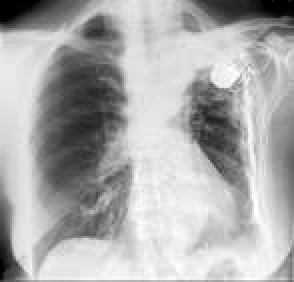
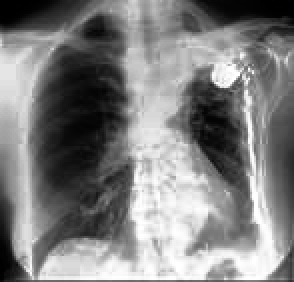


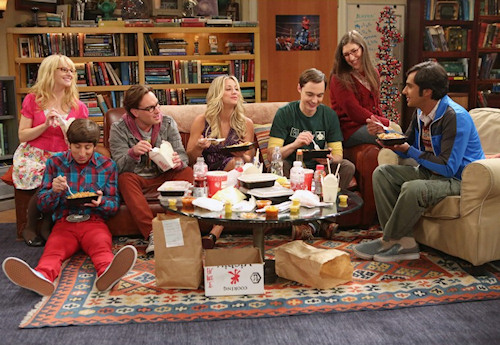
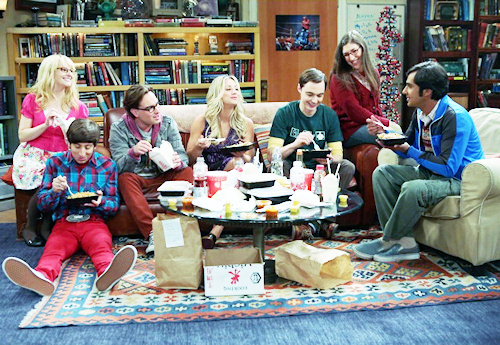
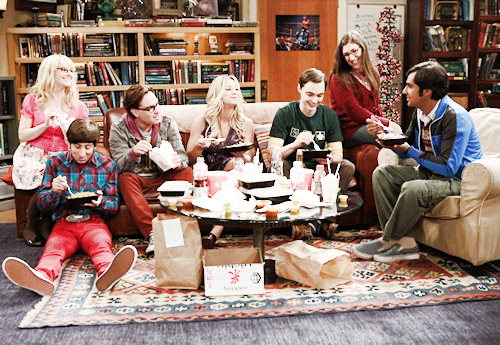

In [6]:
#Equalizzazione di un'immagine grayscale
img = cv.imread('immagini/radio1.png', cv.IMREAD_GRAYSCALE)
res = cv.equalizeHist(img)
va.show((img,"Originale"),(res,"Img Equalizzazione"))
# Equalizzazione di un'immagine a colori
# Esempio di come NON fare: equalizzazione di ciascun canale RGB
bgr = cv.imread('immagini/tbbt.jpg')
b, g, r = cv.split(bgr)
b_eq, g_eq, r_eq = [cv.equalizeHist(x) for x in (b, g, r)]
res_wrong = cv.merge((b_eq, g_eq, r_eq))
# Esempio di come procedere convertendo in HSL ed equalizzando L
hls = cv.cvtColor(bgr, cv.COLOR_BGR2HLS)
h, l, s = cv.split(hls)
l_eq = cv.equalizeHist(l)
hls_eq = cv.merge((h, l_eq, s))
res_ok = cv.cvtColor(hls_eq, cv.COLOR_HLS2BGR)
va.show((bgr,"Img BGR"), (res_wrong,"Eq. Sbagliata "), (res_ok,"Eq. Ok sul canale L"))


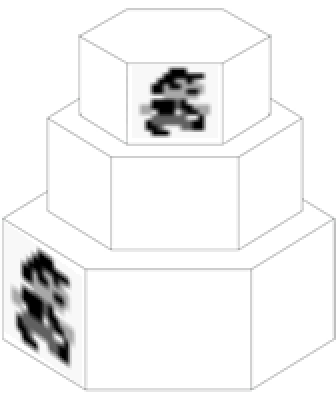

In [7]:
back = cv.imread('Immagini/cake.png')
m = cv.imread('Immagini/mario.png')
h, w = m.shape[:2]
m_pts = np.float32([[1,1],[w-2,1],[1,h-2]])
c_pts = np.float32([
[[ 68, 35],[106, 35],[ 68, 66]],
[[ 4,116],[ 38,140],[ 4,163]] ])

def drawPoints(img, lp):
    for pts in lp:
        for i in range(3):
            p = tuple(pts[i].round().astype(int))
            cv.drawMarker(img, p, (255,0,0), i, 3)
    return img

back_points = drawPoints(back.copy(), c_pts)
m_points = drawPoints(m.copy(), [m_pts])

for pts in c_pts:
    M = cv.getAffineTransform(m_pts,pts)
    cv.warpAffine(m, M, back.shape[1::-1], back, cv.INTER_LINEAR, cv.BORDER_TRANSPARENT)
va.show(back)

### Filtro Lineare $I'[y,x]=\sum_{i,j}\cdot w_{xy}[i,j]\cdot F[i,j]$


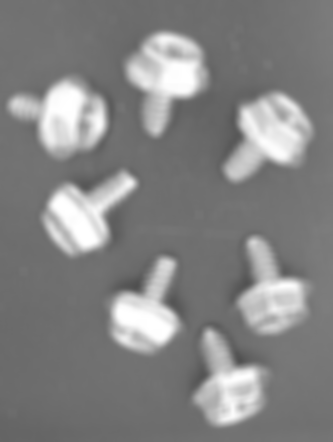
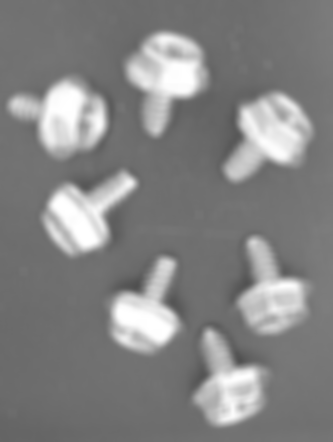

In [8]:
def filter2D_py(img, f):
    start = datetime.datetime.now()
    h, w = img.shape
    kh, kw = f.shape
    dy, dx = kh//2, kw//2
    imgb = cv.copyMakeBorder(img, dy, dy, dx, dx, cv.BORDER_DEFAULT)
    res = np.zeros(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            s = 0
            for i in range(kh):
                for j in range(kw):
                    # N.B. sarebbe imgb[(dy+y)+(i-dy), (dx+x)+(j-dx)]
                    s += imgb[y+i, x+j]*f[i, j]
            res[y, x] = s
    end = datetime.datetime.now()
    return res, int((end - start).total_seconds())

def filter2D_np(img, f):
    start = datetime.datetime.now()
    h, w = img.shape
    kh, kw = f.shape
    dy, dx = kh//2, kw//2
    imgb = cv.copyMakeBorder(img, dy, dy, dx, dx, cv.BORDER_DEFAULT)
    res = np.zeros(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            res[y, x] = (imgb[y:y+kh, x:x+kw]*f).sum()
    end = datetime.datetime.now()
    return res, int((end - start).total_seconds() * 1e3)

# Applicazione di un filtro lineare a un'immagine con OpenCV
# Il risultato è memorizzato su un'immagine di interi con segno a 16 bit
def filter2D_cv(img, f):
    start = datetime.datetime.now()
    res = cv.filter2D(img, cv.CV_16S, f)
    end = datetime.datetime.now()
    return res, int((end - start).total_seconds() * 1e6)

# Misura del tempo di esecuzione delle tre implementazioni
# con un filtro 9x9 con tutti i coefficienti pari a uno.
img = cv.cvtColor(cv.imread('Immagini/bolts.png'), cv.COLOR_BGR2GRAY)
f = np.ones((9,9))
#img_py, time_py = filter2D_py(img,f)
img_np, time_np = filter2D_np(img,f)
img_cv, time_cv = filter2D_cv(img,f)
#va.show((img_py,f'Con Python {time_py} s'),(img_np,f'Con NumPy {time_np} ms'),(img_cv,f'Con OpenCV {time_cv} µs'))
va.show((img_np,f'Con NumPy {time_np} ms'),(img_cv,f'Con OpenCV {time_cv} µs'))

## Filtro Lineare separabile


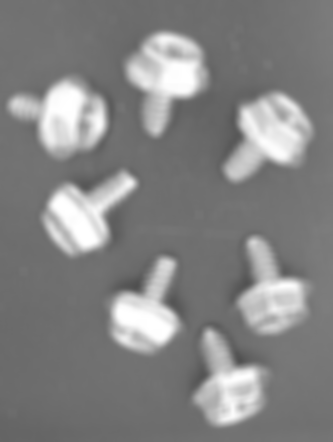
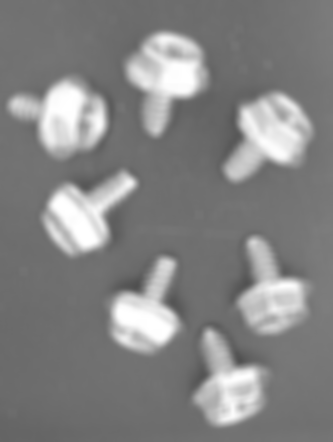
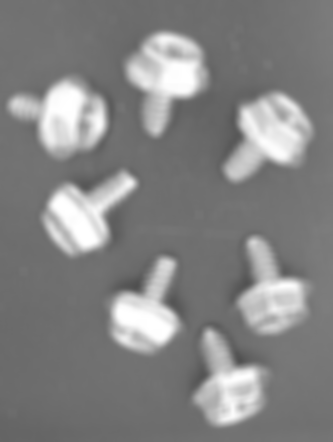

In [9]:
def sepFilter2D_py(img, fX, fY):
    start = datetime.datetime.now()
    fX, fY = fX.ravel(), fY.ravel()
    h, w = img.shape
    kw, kh = fX.size, fY.size
    dy, dx = kh//2, kw//2
    imgb = cv.copyMakeBorder(img, 0, 0, dx, dx, cv.BORDER_DEFAULT)
    t = np.empty(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            t[y, x] = sum(imgb[y, x+j]*fX[j] for j in range(kw))
    tb = cv.copyMakeBorder(t, dy, dy, 0, 0, cv.BORDER_DEFAULT)
    res = np.empty(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            res[y, x] = sum(tb[y+i, x]*fY[i] for i in range(kh))
    end = datetime.datetime.now()
    return res, int((end - start).total_seconds())

def sepFilter2D_np(img, fX, fY):
    start = datetime.datetime.now()
    fX, fY = fX.ravel(), fY.ravel()
    h, w = img.shape
    kw, kh = fX.size, fY.size
    dy, dx = kh//2, kw//2
    imgb = cv.copyMakeBorder(img, 0, 0, dx, dx, cv.BORDER_DEFAULT)
    t = np.empty(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            t[y, x] = (imgb[y, x:x+kw]*fX).sum()
    tb = cv.copyMakeBorder(t, dy, dy, 0, 0, cv.BORDER_DEFAULT)
    res = np.empty(img.shape, dtype=np.int16)
    for y in range(h):
        for x in range(w):
            res[y, x] = (tb[y:y+kh, x]*fY).sum()
    end = datetime.datetime.now()
    return res, int((end - start).total_seconds() * 1e3)

def sepFilter2D_cv(img, fx, fy):
    start = datetime.datetime.now()
    res = cv.sepFilter2D(img, cv.CV_16S, fx, fy)
    end = datetime.datetime.now()
    return res, int((end - start).total_seconds() * 1e6)

img = cv.cvtColor(cv.imread('Immagini/bolts.png'), cv.COLOR_BGR2GRAY)
f = np.ones((9,9))
fx, fy = np.ones((9,1)), np.ones((1,9))
img_py, time_py = sepFilter2D_py(img,fx,fy)
img_np, time_np = sepFilter2D_np(img,fx,fy)
img_cv, time_cv = sepFilter2D_cv(img,fx,fy)
va.show((img_py,f'Con Python {time_py} s'),(img_np,f'Con NumPy {time_np} ms'),(img_cv,f'Con OpenCV {time_cv} µs'))

Metodi con un unico filtro implementati in Python, NumPy, OpenCV



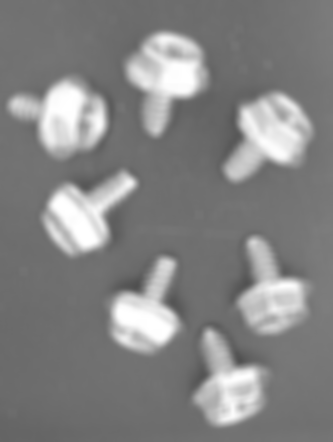
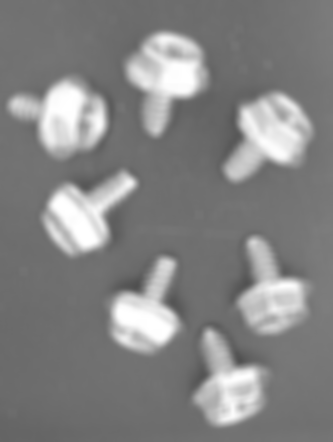
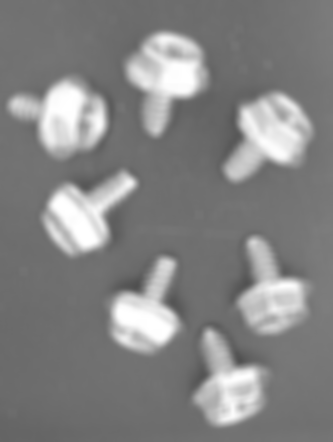

Metodi con i filtri separati implementati in Python, NumPy, OpenCV



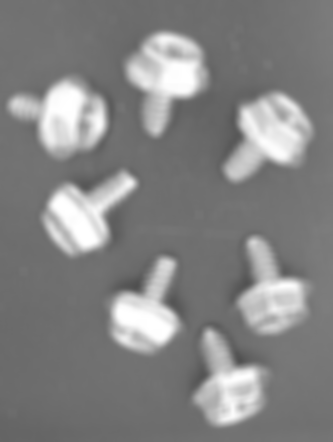
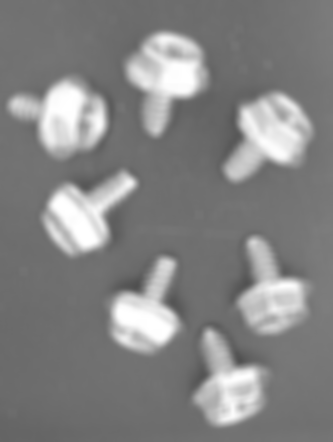
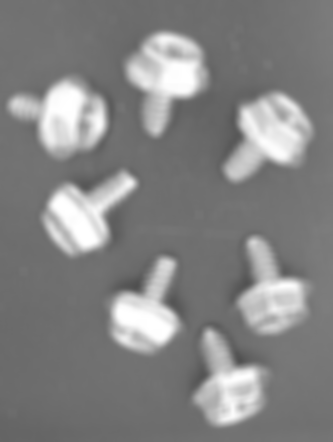

In [10]:
# Comparison
img = cv.cvtColor(cv.imread('Immagini/bolts.png'), cv.COLOR_BGR2GRAY)
f = np.ones((9,9))
fx, fy = np.ones((9,1)), np.ones((1,9))

img_py, time_py = filter2D_py(img,f)
img_np, time_np = filter2D_np(img,f)
img_cv, time_cv = filter2D_cv(img,f)
print("Metodi con un unico filtro implementati in Python, NumPy, OpenCV")
va.show((img_py,f'Con Python {time_py} s'),(img_np,f'Con NumPy {time_np} ms'),(img_cv,f'Con OpenCV {time_cv} µs'))

img_py, time_py = sepFilter2D_py(img,fx,fy)
img_np, time_np = sepFilter2D_np(img,fx,fy)
img_cv, time_cv = sepFilter2D_cv(img,fx,fy)
print("Metodi con i filtri separati implementati in Python, NumPy, OpenCV")
va.show((img_py,f'Con Python {time_py} s'),(img_np,f'Con NumPy {time_np} ms'),(img_cv,f'Con OpenCV {time_cv} µs'))

In [11]:
dim = 3
f_id = np.array(np.tile([0],dim**2), dtype=int).reshape((dim,dim))
f_id[dim//2,dim//2] = 1
f_2 = np.zeros((dim,dim),dtype=int)
f_2[0,dim//2] = 1
dim = 9
f_3 = np.ones((dim,dim),dtype=int)
f_laplaciano = np.array([
    [0,1,0],
    [1,-4,1],
    [0,1,0]],dtype=int)
f_4 = -np.ones((dim,dim),dtype=int)
f_4[dim//2,dim//2] = 8
filters = [('Filtro Identità',f_id),
           ('Traslazione',f_2),
           ('Box Filter',f_3),
           ('Laplaciano',f_laplaciano),
           ('Es_Slide14', f_4)]

In [12]:
@interact(filters_id=(0,len(filters)-1))
def fun(filters_id):
    img = cv.imread('Immagini/hill.jpg')
    img_g = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_f, _ = filter2D_cv(img_g,filters[filters_id][1])
    va.show((img,'Originale'),(img_g,'Gray Scale'),(img_f,filters[filters_id][0]))
    return None

interactive(children=(IntSlider(value=2, description='filters_id', max=4), Output()), _dom_classes=('widget-in…

In [13]:
filters = [
    (coeff * np.array(base,dtype=float).reshape((3,1)), coeff * np.array(base,dtype=float), titolo) 
    for base, titolo, coeff in [ ([-1,0,1],'Derivata Prima', 1/2),
                                 #devo fare derivata prima + questi filtri --> gestione errata
                                 #([1,1,1],'Prewitt',1/2), 
                                 #([1,2,1],'Sobel',1/4),
                                 #([3,10,3],'Scharr',1/16),
                                 ([1,-2,1],'Derivata Seconda', 1/2)]
]

In [14]:
@interact(filters_id=(0,len(filters)-1),
          img_name=["immagini/cat.png","immagini/radio2.png","immagini/torre.jpg","immagini/tbbt.jpg"])
def fun_sep(filters_id,img_name):
    img = cv.imread(img_name)
    img_x, _ = filter2D_cv(img,filters[filters_id][0])
    img_y, _ = filter2D_cv(img,filters[filters_id][1])
    va.show((img,filters[filters_id][2]),(img_x,f'{filters[filters_id][2]} X'),(img_y,f'{filters[filters_id][2]} Y'))
    return None

interactive(children=(IntSlider(value=0, description='filters_id', max=1), Dropdown(description='img_name', op…

## Sharpening Filter

In [15]:
# Metodo 1: filtro di blur e operazioni aritmetiche fra immagini
def apply_sharpen_filter_separated(img, m, k):
    blurred = cv.GaussianBlur(img, (m,m), 0)
    mask = img.astype(np.int16) - blurred
    result = np.clip(np.round(img.astype(float)+k*mask), 0, 255).astype(np.uint8)
    if(not np.array_equal(result,img)) :
        va.show((img,'Originale'),(blurred,'Blurred'),(mask,'Mask'),(result,'Result'))
    else :
        print('Immagine uguale')
    return result

# Metodo 2: creazione di un unico filtro che fa tutto
def apply_sharpen_filter(img, m, k):
    F_b = np.ones((m,m), np.float32)
    F_id = np.zeros_like(F_b)
    F_id[m//2, m//2] = 1
    F_b /= F_b.sum() # Normalizza il filtro di blur
    F_u = F_id + k*(F_id - F_b)
    result = cv.filter2D(img, -1, F_u)
    if(not np.array_equal(result,img)) :
        va.show((img,'Originale'),(result,'Filtro Unico'))
    else :
        print('Immagine uguale')
    return result

In [16]:
@interact(k=(0.0,1.0,0.1),m=(1,15,2))
def apply_sharpen(k,m):
    img = cv.imread('Immagini/kernel.png', cv.IMREAD_GRAYSCALE)
    img_s_sep = apply_sharpen_filter(img, m, k)
    img_s = apply_sharpen_filter_separated(img, m, k)

interactive(children=(FloatSlider(value=0.5, description='k', max=1.0), IntSlider(value=7, description='m', ma…

## Difference of Gaussians (DoG)

In [17]:
@interact(sigma_1=(1,10),sigma_2=(1,10))
def DoG(sigma_1,sigma_2):
    if(sigma_1 >= sigma_2):
        sigma_2 = sigma_1 + 1
    img = cv.imread('Immagini/cat.png')
    img_g = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_b1 = cv.GaussianBlur(img_g,None,sigma_1).astype(float)
    img_b2 = cv.GaussianBlur(img_g,None,sigma_2).astype(float)
    result = img_b1-img_b2
    norm = result.copy()
    norm[norm<2] = 0
    norm = cv.normalize(norm,None, 0, 255, cv.NORM_MINMAX)
    va.show((img, 'Originale'),(img_g, 'Gray Scale'),(img_b1, f'Blurred sigma = {sigma_1}'),
            (img_b2, f'Blurred sigma = {sigma_2}'), (result, 'Result'), (norm, 'Normalized'))
    return None

interactive(children=(IntSlider(value=5, description='sigma_1', max=10, min=1), IntSlider(value=5, description…

## Prewitt Sobel Scharr


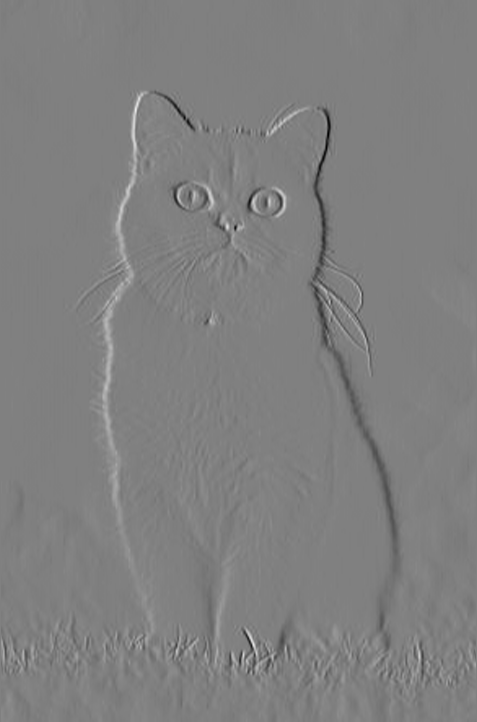
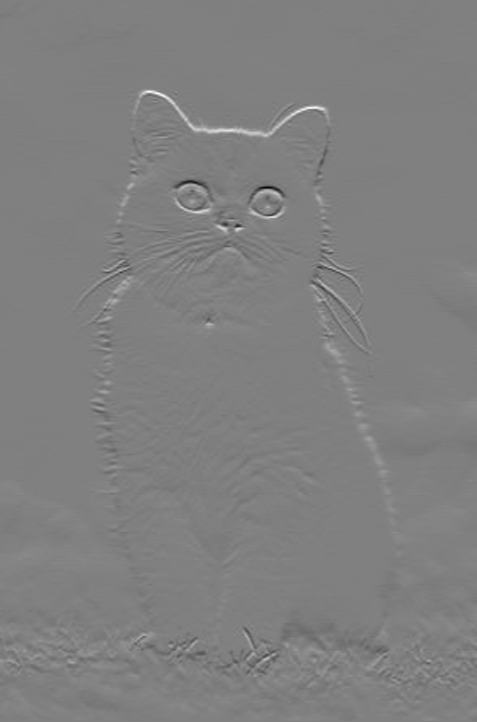
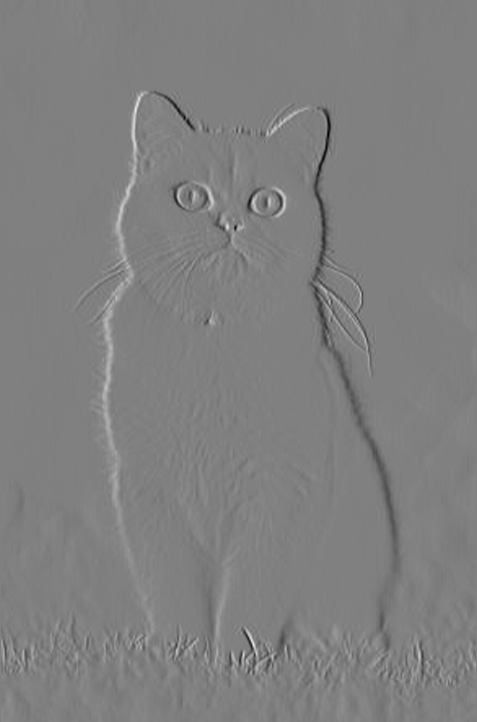
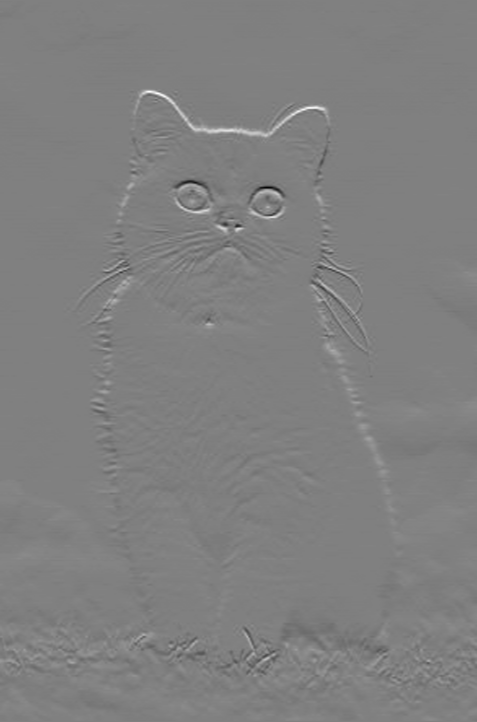
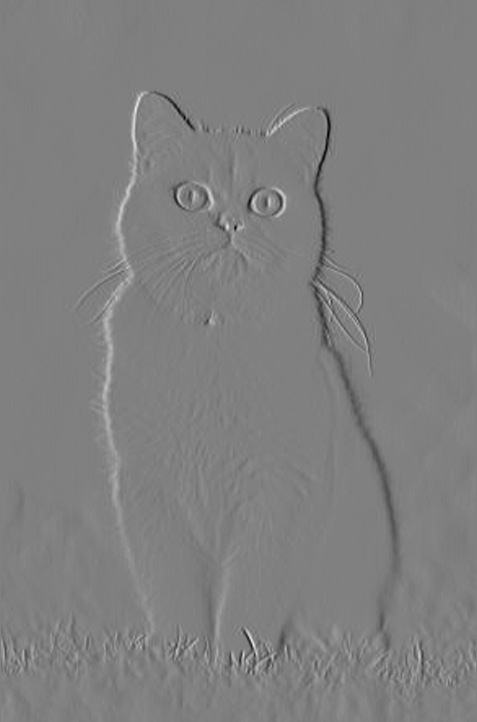
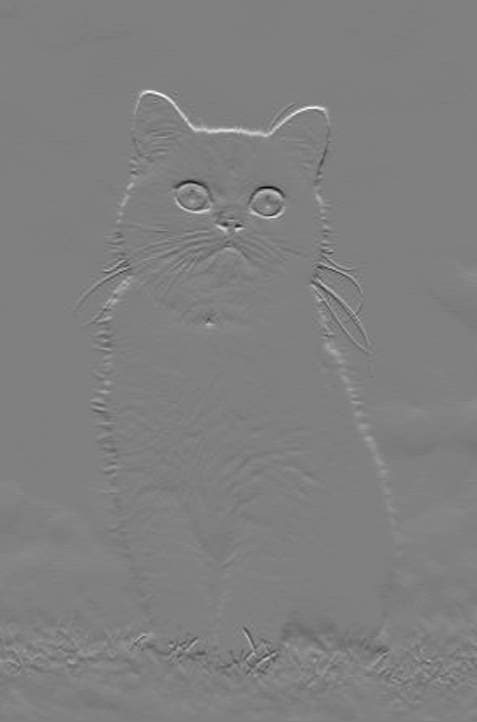

In [18]:
def derivata(img, t, d):
    s = {'Prewitt': [1,1,1], 'Sobel': [1,2,1], 'Scharr': [3,10,3]}[t]
    D = np.float32([-1,0,1])/2
    S = np.float32(s)/np.float32(s).sum()
    fx, fy = (D, S) if d=='x' else (S, D)
    return cv.sepFilter2D(img, cv.CV_32F, fx, fy)

img = cv.imread('Immagini/cat.png', flags=cv.IMREAD_GRAYSCALE)
res = [(derivata(img,t,d), f'{t} ({d})')
        for t in ('Prewitt', 'Sobel', 'Scharr')
            for d in ('x', 'y')]

va.show(*res, max_per_row=2)

## Visualizzare modulo e angolo del gradiente in OpenCV (copy)

m prima della normalizzazione 
 [[ 0.        6.        6.        6.        6.       10.        8.
   6.        4.        4.      ]
 [12.       12.083046 10.29563  10.       10.       12.806249 11.313708
  10.       10.29563  10.770329]]
m dopo la normalizzazione 
 [[0 2 2 2 2 4 3 2 2 2]
 [5 5 4 4 4 5 4 4 4 4]]



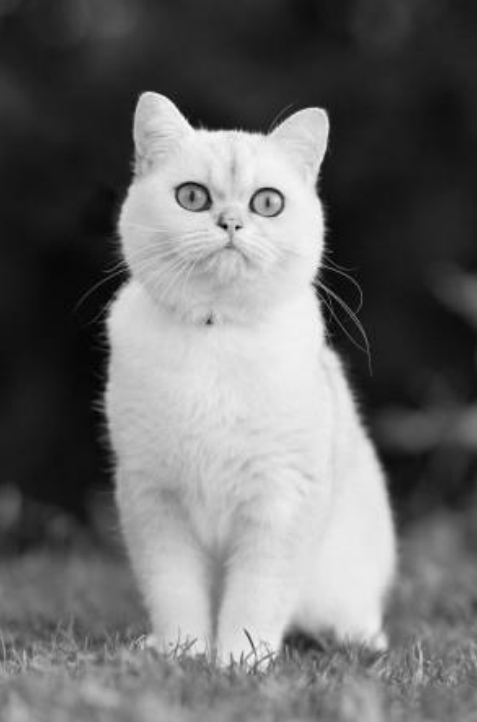
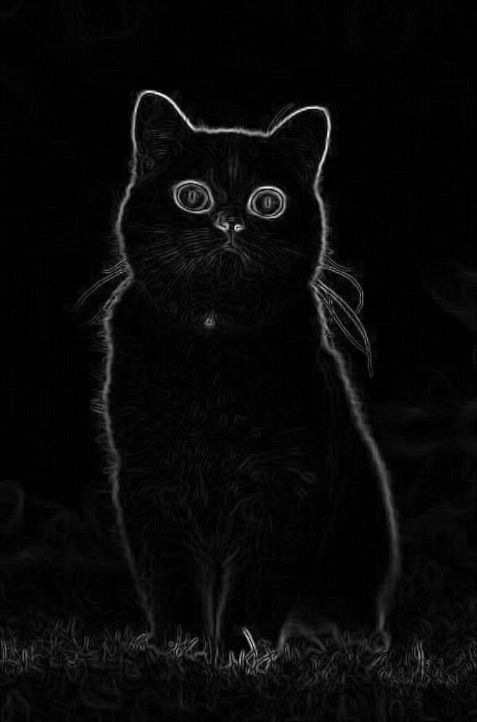
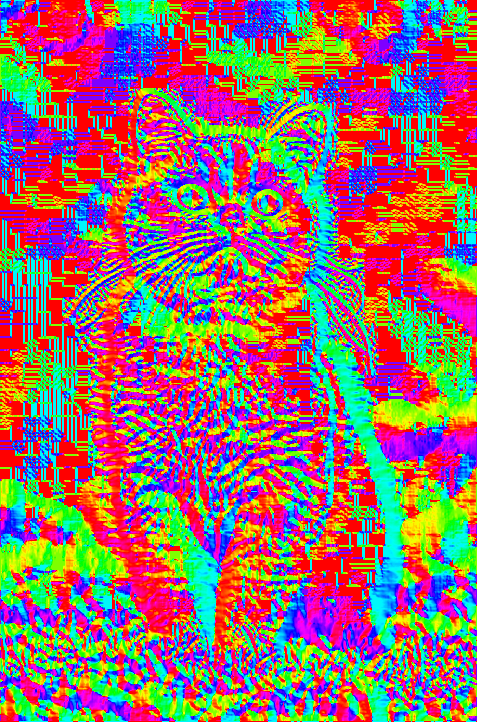


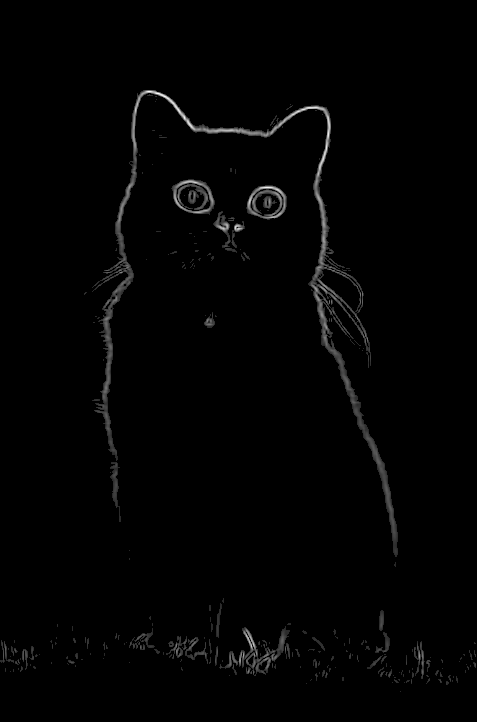
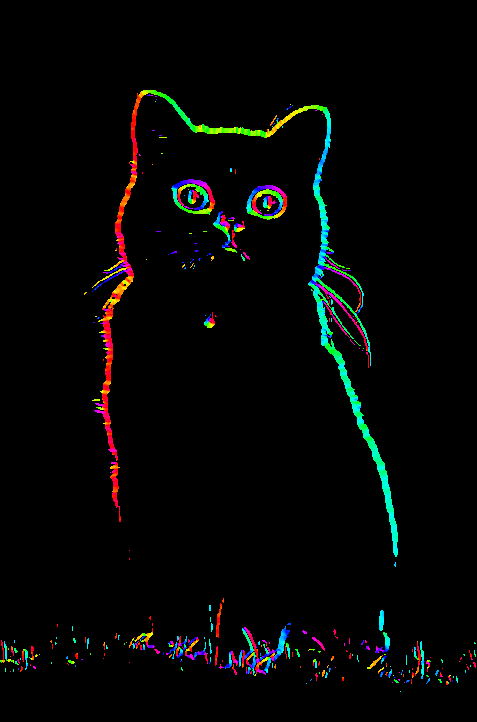

In [19]:
img = cv.imread('Immagini/cat.png', flags=cv.IMREAD_GRAYSCALE)
dx, dy = cv.spatialGradient(img)
dx, dy = dx.astype(np.float32), dy.astype(np.float32)
# Calcola il modulo del gradiente per ciascun pixel 
m = cv.magnitude(dx, dy) # Calcola l'angolo del gradiente per ciascun pixel (in radianti)
print("m prima della normalizzazione \n",m[:2,:10])
a = cv.phase(dx, dy) # Converte i moduli nel range [0,255]
m = cv.normalize(m, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U) # Converte gli angoli da [0,2pi] a [0,255] 
print("m dopo la normalizzazione \n",m[:2,:10])
a = (a/(2*np.pi)*255).round().astype(np.uint8)
a = cv.applyColorMap(a, cv.COLORMAP_HSV) # Angolo -> Hue
# Visualizza solo i gradienti con modulo superiore a una soglia 
t = 40
a1 = a.copy()
a1[m < t] = 0
m1 = m.copy()
m1[m < t] = 0
va.show((img,'Originale'),(m,'m(magnitude = angolo del gradiente) in [0,255]'),(a,'a = phase'))
va.show((m1,f'm < t; t={t}'),(a1,f'a < t; t={t}'))

In [20]:
@interact(kernel_size=(3,12,2),t1=(50,1000),t2=(50,1000),
         img_name=["immagini/cat.png","immagini/radio2.png","immagini/torre.jpg","immagini/tbbt.jpg"])
def calc_edges(kernel_size,t1,t2,img_name):
    if t1 > t2 :
        img = cv.imread(img_name)
        img_b = cv.GaussianBlur(cv.cvtColor(img, cv.COLOR_BGR2GRAY), (kernel_size, kernel_size), 0)
        edges = cv.Canny(img_b, t1, t2)
        img_e = img.copy()
        img_e[edges!=0]=(0,0,255)
        va.show((img,'Originale'),(edges,'Bordi'),(img_e,'Image with edges'))
    return None

interactive(children=(IntSlider(value=7, description='kernel_size', max=12, min=3, step=2), IntSlider(value=52…

## Un esempio completo di estrazione contorni in OpenCV

In [21]:
@interact(s1=(0,255),w=(1,4),s_area=(24,150))
def main(s1=232, w=2, s_area=100):
    img = cv.imread('Immagini/donuts.png')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Binarizza con soglia 253 (lo sfondo è bianco)
    _, binarized = cv.threshold(gray, s1, 255, cv.THRESH_BINARY_INV)

    # La funzione restituisce anche una struttura dati ad albero che contiene eventuali
    # relazioni fra contorni (un contorno "padre" contiene uno o più "figli")
    contours, trees = cv.findContours(binarized, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    # Disegna tutti i contorni trovati
    img_with_cc = cv.drawContours(img.copy(), contours, -1, (0,0,0), w)
    
    # Esclude i contorni con area piccola e abbina due flag booleani per sapere se
    # il contorno ha un padre e/o figli
    # prima di fare i calcoli (crare la lista info) sarebbe da aggirnare trees
    info = [(c, trees[0,i,2]>=0, trees[0,i,3]>=0) for i, c in enumerate(contours) if cv.contourArea(c) > s_area]
    res = img.copy()
    
    for c, p, f in info:
        color = (0,0,0) # defaul nero
        if p :
            color = (255, 0, 0) # padre = blu
        elif f:
            color = (0, 255, 0) # figlio = verde
        cv.drawContours(res, [c], -1, color, w)
    #va.show(res)
    va.show(binarized, img_with_cc, res, max_per_row=2)

interactive(children=(IntSlider(value=232, description='s1', max=255), IntSlider(value=2, description='w', max…

## Funzioni applicate ai contorni

In [22]:
@interact(fun_name=["fitLine", "fitEllipse", "boundingRect","minAreaRect",
               "minEnclosingTriangle","minEnclosingCircle","convexHull"],
         s1=(0,255))
def main(fun_name="fitLine",s1=152):
    bolts = cv.imread('Immagini/bolts.png')
    bolts_g = cv.cvtColor(bolts, cv.COLOR_BGR2GRAY)
    _, bolts_bin = cv.threshold(bolts_g, s1, 255, cv.THRESH_BINARY_INV)
    contours, trees = cv.findContours(bolts_bin, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    bolts_with_c = cv.drawContours(bolts.copy(), contours, -1, (255,0,0), 1)
    bolts_with_fun = bolts_with_c.copy()
    
    for i in range(1, len(contours)) :
        if(fun_name == "fitLine"):
            a = 1
        elif fun_name == "fitEllipse":
            a = 1
        elif fun_name == "boundingRect":
            a = 1
        elif fun_name == "minAreaRect":
            a = 1
        elif fun_name == "minEnclosingTriangle":
            a = 1
        elif fun_name == "minEnclosingCircle":
            a = 1
        elif fun_name == "convexHull":
            a = 1
            
    va.show((bolts,"Immagine"), 
            (bolts_bin,"Img Binarizzata"), (bolts_with_c, "Img With Contours"),
            (bolts_with_fun, "Img With Function"), max_per_row=2
           )
    return None

interactive(children=(Dropdown(description='fun_name', options=('fitLine', 'fitEllipse', 'boundingRect', 'minA…

## Etichettatura delle componenti connesse in OpenCV

In [23]:
def get_color_comp(a,b,t):
    return int(a + (b - a) * t)

def get_color(a,b,t):
    return (get_color_comp(a[0],b[0],t),
            get_color_comp(a[1],b[1],t),
            get_color_comp(a[2],b[2],t))

def color_list(a,b,n):
    return [get_color(a,b,i/n) for i in range(n)]

def map_connection_component(cc, n, colors):
    res = cc.copy()
    res = np.stack((res,)*3,axis=-1)
    for i in range(n):
        res[cc==(i+1)]=colors[i%len(colors)]
    return res

In [24]:
@interact(img_name=["rice.png","bolts.png"], s1=(0,255),
          use_close_morph=False, ks_size=(3,15))
def main(img_name, s1, use_close_morph, ks_size) :
    img = cv.imread("Immagini/"+img_name, cv.IMREAD_GRAYSCALE)
    if not use_close_morph :
        _, bw = cv.threshold(img, s1, 255, cv.THRESH_BINARY)
        n, cc = cv.connectedComponents(bw)
        va.show((img,"Originale"), (bw,"Immagine Binaria"), 
                (map_connection_component(cc,n,color_list([255,255,0],[255,0,255],10)),"CC Mapped"))
    else :
        _, bw = cv.threshold(img, s1, 255, cv.THRESH_BINARY)
        s = cv.getStructuringElement(cv.MORPH_ELLIPSE, (ks_size,ks_size))
        img_o = cv.morphologyEx(bw, cv.MORPH_OPEN, s)
        img_oc = cv.morphologyEx(img_o, cv.MORPH_CLOSE, s)
        n, cc = cv.connectedComponents(img_oc)
        img_oc_ori = img.copy()
        img_oc_ori[img_oc == 0] = 0
        va.show((img,"Originale"), (bw,"Immagine Binaria"), (img_oc,"Immagine Lavorata"), 
                (map_connection_component(cc,n,color_list([255,255,0],[255,0,255],10)),"CC Mapped"),
                (img_oc_ori,"Or. Masked"), max_per_row=3
               )
    print(f'Componenti connesse: {n}')
    return None

interactive(children=(Dropdown(description='img_name', options=('rice.png', 'bolts.png'), value='rice.png'), I…

## Morfologia matematica
 - Erosione
 - Dilatazione
 - Chiusura
 - Apertura

In [29]:
# Altre matrici elementari
err = np.array([
                [1,1,1,1],
                [1,1,0,1],
                [1,1,0,1],
                [1,1,1,1]
               ])
err1 = np.array([
                [1,1,1,1],
                [1,1,1,1],
               ])
# Errore
cm = [err, err1]

In [28]:
@interact(ks_size=(5,15), use_custom_matrix = False, id_matrix=(0,len(cm)-1))
def main(ks_size,use_custom_matrix,id_matrix):
    img = cv.imread("Immagini/butterfly.png", cv.IMREAD_GRAYSCALE)
    se = cv.getStructuringElement(cv.MORPH_RECT, (ks_size,ks_size))
    if use_custom_matrix :
        se = cm[id_matrix]
    
    d = cv.morphologyEx(img, cv.MORPH_DILATE, se)
    e = cv.morphologyEx(img, cv.MORPH_ERODE, se)    
    
    d1 = cv.cvtColor(d, cv.COLOR_GRAY2BGR)
    d1[d - img != 0] = (0, 255, 0)
    e1 = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    e1[e - img != 0] = (0, 128, 255)
    va.show((img, "Immagine"), (d1, "Dilatazione"), (e1,"Erosione"))

interactive(children=(IntSlider(value=10, description='ks_size', max=15, min=5), Checkbox(value=False, descrip…